In [1]:
import ngmix
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
import time
#from galsim.gsparams import GSParams
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import shape_measurement as sm

In [2]:
gsparams = galsim.GSParams(kvalue_accuracy=1.e-5,maximum_fft_size=2048*10,maxk_threshold=1.e-5)


In [165]:
pixel_scale = 0.1 #as/px
lamda = 550 #nm
diameter = 1.2 #m
psf_oversample = 2.
gal_oversample = 2.

airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel)

#image_psf = psf.drawImage(scale=pixel_scale/20.,method='no_pixel') #Fit a Gaussian
#psf_gaussian = makeGaussian(image_psf,gsparams=gsparams)[0]

psf_gaussian = psf #Now a misnomer, make it Airy
given_psf = psf_gaussian.drawImage(scale=pixel_scale/psf_oversample,method='no_pixel') #Draw oversampled psf image

#gauss_psfii = psf_gaussian
gauss_psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)


In [166]:

#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.5))[0][0] #Large galaxies, reasonable sersic n
gal = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)


In [167]:
fin = galsim.Convolve([gal,psf_gaussian])
given_im = fin.drawImage(scale=pixel_scale/gal_oversample, method='no_pixel')

In [152]:
jac_psf=ngmix.jacobian.DiagonalJacobian(scale=pixel_scale/psf_oversample,row=0,col=0)
jac_gal=ngmix.jacobian.DiagonalJacobian(scale=pixel_scale/gal_oversample,row=0,col=0)

In [153]:
psfObs = ngmix.observation.Observation(given_psf.array,jacobian=jac_psf)
obs=ngmix.observation.Observation(given_im.array,psf=psfObs,jacobian=jac_gal)

In [154]:
metacal=ngmix.metacal.get_all_metacal(obs,0.0,False)

In [155]:
recImArr=(metacal['1p'].image)

In [156]:
recImArr.shape

(224, 224)

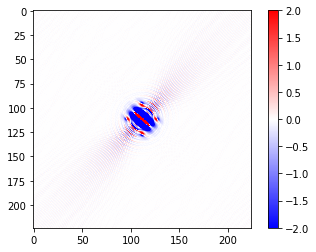

In [157]:
plt.imshow((given_im.array - recImArr)*1e6,vmin=-2,vmax=2,cmap=cm.bwr)
plt.colorbar()

In [168]:
orig_shape_obs=galsim.hsm.FindAdaptiveMom(given_im).observed_shape
print orig_shape_obs

galsim.Shear(g1=0.0367634879592,g2=0.314942563011)


In [169]:
print given_psf.scale

0.05


In [170]:
recIm=galsim.ImageF(recImArr,scale=pixel_scale/gal_oversample)

In [171]:
orig_shape= galsim.hsm.EstimateShear(given_im, given_psf)
orig_obs = orig_shape.observed_shape
orig_corr = (orig_shape.corrected_e1, orig_shape.corrected_e2)

rec_shape = galsim.hsm.EstimateShear(recIm, given_psf)
rec_corr = (rec_shape.corrected_e1, rec_shape.corrected_e2)

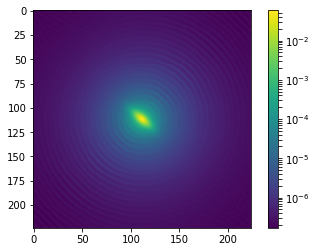

In [172]:
plt.imshow(given_im.array,norm=LogNorm())
plt.colorbar()

In [173]:
orig_corr

(0.086703822016716, 0.7422909736633301)

In [174]:
np.abs(rec_corr[0] - orig_corr[0]), np.abs(rec_corr[1] - orig_corr[1])

(0.0018670633435249329, 0.016008496284484863)

In [175]:
print gal.

SyntaxError: invalid syntax (<ipython-input-175-4662e40c97a7>, line 1)

In [176]:
shear = galsim.Shear(g1=0.05493919119883436,g2=0.46971950650886507)
print shear.e1, shear.e2

0.0897952500379 0.767732098239


In [177]:
print np.abs(shear.e1 - orig_corr[0]), np.abs(shear.e2 - orig_corr[1])

0.003091428021148118 0.025441124575505736


In [178]:
orig_shape=galsim.hsm.FindAdaptiveMom(given_im).observed_shape
#print orig_shape.e1, orig_shape.e2

rec_shape=galsim.hsm.FindAdaptiveMom(recIm).observed_shape
#print rec_shape.e1, rec_shape.e2
print np.abs(rec_shape.e1-orig_shape.e1), np.abs(rec_shape.e2-orig_shape.e2)

0.0010365471243858337 0.008913278579711914


In [180]:
0.*np.inf

nan